This is a notebook aimed to follow the tutorial laid out on https://readmedium.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca

### Import neccessary libraries

In [2]:
import numpy as np
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

import tensorflow.keras as K

from tensorflow_probability import distributions as tfd

from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing() # had to use california instead of boston


import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings("always")

warnings.filterwarnings(
    "ignore",
    message=r"You are using a softmax over axis -1 of a tensor of shape.*"
)

print("successfully imported all")


def remove_ax_window(ax):
    """
    Function to remove all axes and tick parameters in pyplot - cosmetic
    """
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Some default parameters for plotting
dpi = 140
x_size = 8
y_size = 4
alt_font_size = 14

save_figure = False
use_tb = False

successfully imported all


### Define our MDN

In [3]:
# Inherit from the tf.keras.Model class - its the core class for building trainable models, allows you to define on custom layers while maintaining the high level keras training tools
class MDN(tf.keras.Model):
    """Our custom MDN class"""

    def __init__(self, neurons=100, components=2):
        super(MDN, self).__init__(name='MDN') # inherits the parent class and names it (for debugging)
        self.neurons = neurons
        self.components = components

        # weight layers to learn
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")

        self.alphas = Dense(components, activation="softmax", name="alphas") # impose sum to unity
        self.mus = Dense(components, name="mus")
        self.sigmas = Dense(components, activation=nnelu, name="sigmas") # custom nnelu defined later
        self.pvec = Concatenate(name="pvec") #Used to combine the 3 above in the call function

    def call(self, inputs):
        """
        Forward pass of MDN
        """
        x = self.h1(inputs)
        x = self.h2(x)

        alpha_v = self.alphas(x)
        mus_v = self.mus(x)
        sigma_v = self.sigmas(x)

        return self.pvec([alpha_v, mus_v, sigma_v])


class DNN(tf.keras.Model):
    """
    Our custom DNN class
    """

    def __init__(self, neurons=100):
        super(DNN, self).__init__(name='DNN') # inherits the parent class and names it (for debugging)
        self.neurons = neurons

        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        self.out =  Dense(1, activation="linear", name="out")

    def call(self, inputs):
        """
        Forward pass of DNN
        """
        x = self.h1(inputs)
        x = self.h2(x)

        return self.out(x)

### Define some custom helper functions

In [4]:
def nnelu(input):
    """
    Computes the Non negative ELU by adding 1 to the default as seen in the article
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """
    Unpacks the list of parameter vectors into a list of 2d tensors each with shape (batch_size, components), one for each parameter
    """
    return [parameter_vector[:,i*components:(i+1)*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """
    Computes the mean negative log likelihood of y given the mixture parameters
    """

    alpha, mu, sigma = slice_parameter_vectors(parameter_vector) # unpack using above function

    # This defines the mixed gaussian model where alpha is the mixture weights, mu the mean vector, sigma the standard deviations - we are in univariate case here
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(loc=mu, scale=sigma),
    )

    log_likelihood = gm.log_prob(tf.transpose(y)) # evaluate the log probability of y

    return -tf.reduce_mean(log_likelihood, axis=-1)

tf.keras.utils.get_custom_objects().update({'nnelu': nnelu}) # make the nnelu available to be used in our layers

### Define our paramaters and train the model

In [5]:
no_parameters = 3
components = 1
neurons = 100

 # define our optimiser to be the adam optimiser
opt_mdn = tf.keras.optimizers.Adam(learning_rate=1e-3)
opt_dnn = tf.keras.optimizers.Adam(learning_rate=1e-3)   # ← brand-new instance to avoid issues later

# monitors val loss and stops early if doesnt improve for a certain number of epochs, min_delta means that any improvement counts, patience means wait for that many with no improvement, verbose is to do with logging, mode is whether we maximise or minimise
mon = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [6]:
mdn = MDN(neurons=neurons, components=components) # instantiate our mdn
mdn.compile(loss=gnll_loss, optimizer=opt_mdn) # prepares model for training by declaring loss and optimiser

In [7]:
dnn = DNN(neurons=neurons) # instantiate our dnn
dnn.compile(loss="mse", optimizer=opt_dnn, run_eagerly=True) # prepares model for training by declaring loss and optimiser

### Now we do the linear example

In [8]:
samples = int(1e5)

# generate the number of random samples between 1 and 1 and an axis
x_data = np.random.sample(samples)[:, np.newaxis].astype(np.float32)
# y = 5x + x^2 N(0,1)
y_data = np.add(5*x_data, np.multiply(x_data**2, np.random.randn(*x_data.shape)))

# split into test and training data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.5, random_state=42)


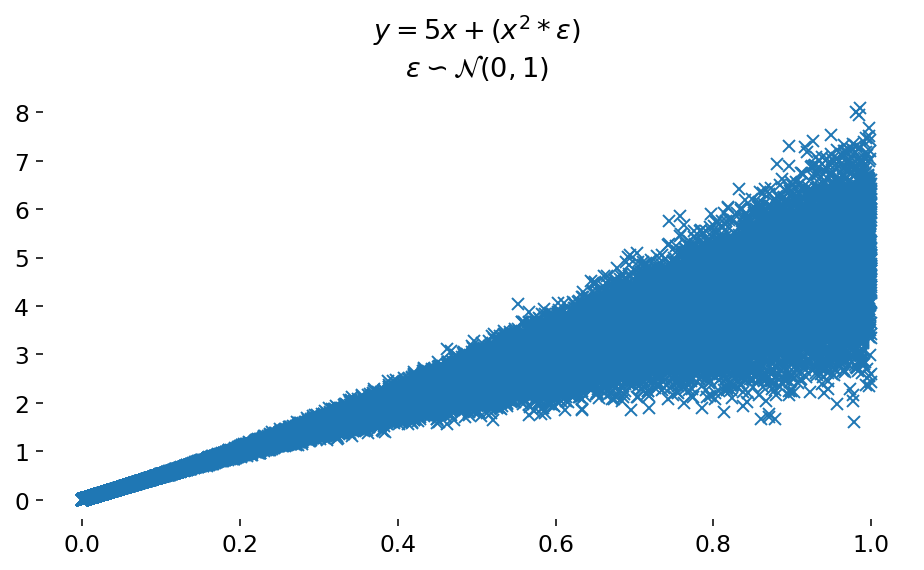

In [9]:
# create plot using the previously defined settings
fig = plt.figure(figsize=(x_size, y_size), dpi=dpi)
ax = plt.gca()

ax.set_title(r"$y = 5x + (x^2 * \epsilon)$"+"\n"+r"$\epsilon \backsim \mathcal{N}(0,1)$", fontsize=alt_font_size)
ax.plot(x_train,y_train, "x",alpha=1., color=sns.color_palette()[0])

remove_ax_window(ax)
plt.show()

Now we will train out model on this data aiming to learn the relationship

In [10]:
%%time
# this is just used to predict against
s = np.linspace(0.,1.,int(1e3))[:, np.newaxis].astype(np.float32)

# fit the model using the appropriate data
mdn.fit(x=x_train, y=y_train, epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)
y_pred = mdn.predict(s)

# get the desired params out using the above function
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
CPU times: user 7.71 s, sys: 1.37 s, total: 9.08 s
Wall time: 6.39 s


Now just plot this alongside the previous so we can see our results

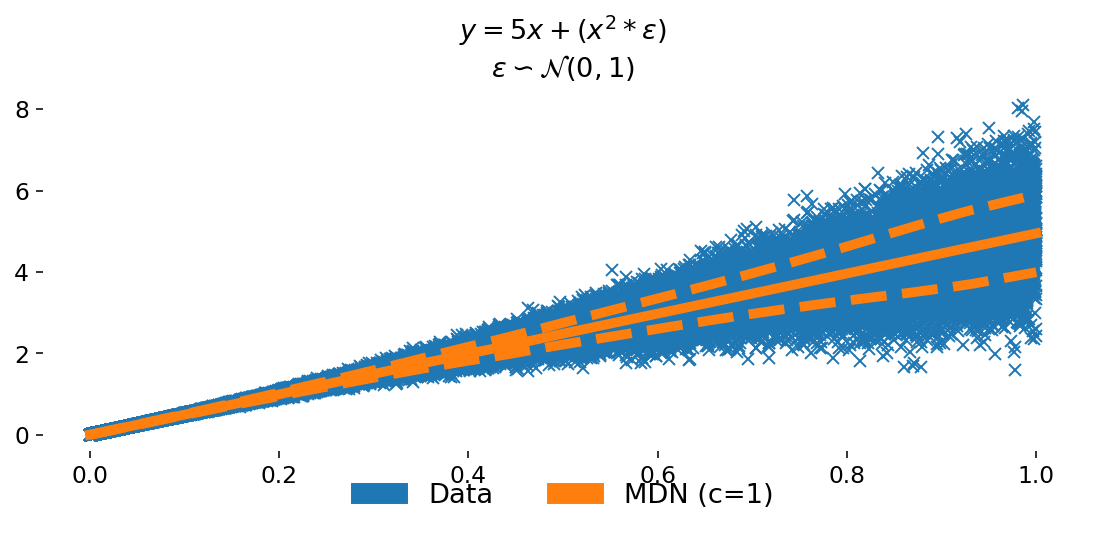

In [11]:
fig = plt.figure(figsize=(x_size,y_size), dpi=dpi)
ax = plt.gca()

ax.set_title(r"$y = 5x + (x^2 * \epsilon)$"+"\n"+r"$\epsilon \backsim \mathcal{N}(0,1)$", fontsize=alt_font_size)
ax.plot(x_train,y_train, "x",alpha=1, color=sns.color_palette()[0])

# plot the mean + the standard deviations
plt.plot(s,mu_pred+sigma_pred, color=sns.color_palette()[1],linewidth=5, linestyle='--', markersize=3)
plt.plot(s,mu_pred-sigma_pred, color=sns.color_palette()[1],linewidth=5, linestyle='--', markersize=3)
plt.plot(s,mu_pred, color=sns.color_palette()[1],linewidth=5, linestyle='-', markersize=3)

remove_ax_window(ax)

data_leg = mpatches.Patch(color=sns.color_palette()[0])
data_mdn = mpatches.Patch(color=sns.color_palette()[1])

ax.legend(handles = [data_leg, data_mdn],
          labels = ["Data", "MDN (c=1)"],
          loc=9, borderaxespad=0.1, framealpha=1.0, fancybox=True,
          bbox_to_anchor=(0.5, -0.05), ncol=2, shadow=True, frameon=False,
          fontsize=alt_font_size)

plt.tight_layout()

if save_figure:
    plt.savefig("graphics/mdn_linear_prediction.png", format='png',dpi=dpi, bbox_inches='tight')

plt.show()


Can see that the MDN is able to successfully capture the linear nature as well as also capturing the increase in the standard deviation goes on

### Loss for this linear example

In [12]:
def gnll_eval(y, alpha, mu, sigma):
    """Computes the mean negative log likelihood of y given the mixture parameters"""
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(loc=mu, scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)

# build one Mean-Squared-Error callable we can reuse
_mse = tf.keras.losses.MeanSquaredError(reduction="none")

def eval_null_model(y_test):
    """
    Evaluates the null model which is the sample mean and standard deviation
    """
    mu_pred    = np.full_like(y_test, np.mean(y_test), dtype=np.float32)
    alpha_pred = np.ones_like(mu_pred, dtype=np.float32)
    sigma_pred = np.full_like(mu_pred, np.std(y_test), dtype=np.float32)

    print("NULL-MSE: {:1.3f}".format(
          tf.reduce_mean(_mse(y_test, mu_pred)).numpy()))
    print("NULL-NLL: {:1.3f}\n".format(
          gnll_eval(y_test.astype(np.float32),
                    alpha_pred, mu_pred, sigma_pred).numpy()[0]))
    return None


def eval_linear_model(x_test, y_test, linear_model):
    """
    Evaluates the linear model which is the linear best fit + the std deviation of sample
    """
    mu_pred    = linear_model.predict(x_test).astype(np.float32)
    alpha_pred = np.ones_like(mu_pred, dtype=np.float32)
    sigma_pred = np.full_like(mu_pred, np.std(y_test), dtype=np.float32)

    print("LIN-MSE: {:1.3f}".format(
          tf.reduce_mean(_mse(y_test, mu_pred)).numpy()))
    print("LIN-NLL: {:1.3f}\n".format(
          gnll_eval(y_test.astype(np.float32),
                    alpha_pred, mu_pred, sigma_pred).numpy()[0]))
    return None


def eval_dnn_model(x_test, y_test, dnn_model):
    """
    Evaluates the DNN model on the data, again use sample std.
    """
    mu_pred = dnn_model.predict(x_test, verbose=0).astype(np.float32)
    alpha_pred = np.ones_like(mu_pred, dtype=np.float32)
    sigma_pred = np.full_like(mu_pred, np.std(y_test), dtype=np.float32)

    # Compute loss values
    mse = tf.reduce_mean(_mse(y_test, mu_pred)).numpy()
    nll = gnll_eval(y_test.astype(np.float32),
                    alpha_pred, mu_pred, sigma_pred).numpy()

    print("DNN-MSE: {:1.3f}".format(mse))
    print("DNN-NLL: {:1.3f}\n".format(float(np.mean(nll))))
    # ------------------------------------------

    return None


def eval_mdn_model(x_test, y_test, mdn_model):
    """
    Evaluates the MDN model on the data
    """
    y_pred  = mdn_model.predict(x_test, verbose=0)
    alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

    mix_mean = np.multiply(alpha_pred, mu_pred).sum(axis=-1)[:, np.newaxis]
    print("MDN-MSE: {:1.3f}".format(
          tf.reduce_mean(_mse(y_test, mix_mean)).numpy()))
    print("MDN-NLL: {:1.3f}\n".format(
          gnll_eval(y_test.astype(np.float32),
                    alpha_pred, mu_pred, sigma_pred).numpy()[0]))
    return None


Train the DNN, and the linear regression

In [13]:
%%time
# fit the DNN to data
dnn.fit(x=x_train, y=y_train,epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)

lr = LinearRegression()
lr.fit(x_train, y_train)

CPU times: user 28.5 s, sys: 386 ms, total: 28.9 s
Wall time: 28.1 s


LinearRegression()

Can now use the functions to evaluate the MSE and NLL

In [14]:
eval_null_model(y_test)
eval_linear_model(x_test, y_test, lr)
eval_dnn_model(x_test, y_test, dnn)
eval_mdn_model(x_test, y_test, mdn)

NULL-MSE: 2.280
NULL-NLL: 1.831

LIN-MSE: 0.200
LIN-NLL: 1.375

DNN-MSE: 0.200
DNN-NLL: 1.375

MDN-MSE: 0.201
MDN-NLL: -0.467



We see that all models beat the null model which is to be expected.

MSE assumes the std deviation of the underlying distribution is constant and so we cant tell the remaining 3 apart with that alone.

However using NLL which does incoorporate the std deviation we see that the MDN is better able to approximate the distribution



### Non Linear Example

In [15]:
# Set up our data for this problem
x_data = np.float32(np.random.uniform(-10, 10, (1, samples)))
r_data = np.array([np.random.normal(scale=np.abs(i)) for i in x_data])
y_data = np.float32(np.square(x_data)+r_data*2.0)

x_data2 = np.float32(np.random.uniform(-10, 10, (1, samples)))
r_data2 = np.array([np.random.normal(scale=np.abs(i)) for i in x_data2])
y_data2 = np.float32(-np.square(x_data2)+r_data2*2.0)

x_data = np.concatenate((x_data,x_data2),axis=1).T
y_data = np.concatenate((y_data,y_data2),axis=1).T

min_max_scaler = MinMaxScaler()
y_data = min_max_scaler.fit_transform(y_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.5, random_state=42, shuffle=True)

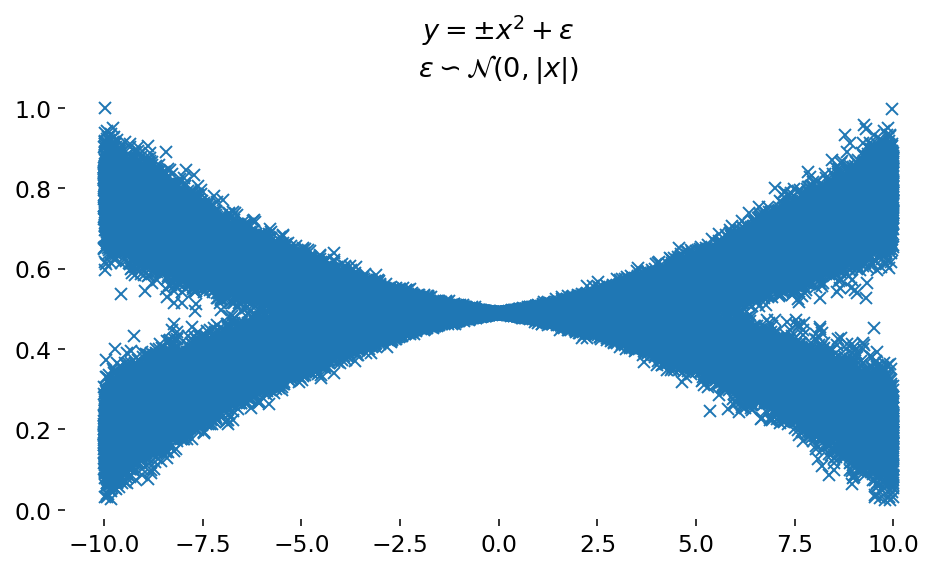

In [16]:
# Plot the data
fig = plt.figure(figsize=(x_size,y_size), dpi=dpi)
ax = plt.gca()

ax.set_title(r"$y = \pm x^2 + \epsilon$"+"\n"+r"$\epsilon\backsim\mathcal{N}(0,|x|)$", fontsize=alt_font_size)
ax.plot(x_train,y_train, "x",alpha=1., color=sns.color_palette()[0])

remove_ax_window(ax)
plt.show()

Can see the 2 mode non linear output so aim to capture this using 2 components this time.

In [17]:
no_parameters = 3
components = 2
neurons = 200

In [18]:
# define new mdn, also define new optimiser

opt_mdn2 = tf.keras.optimizers.Adam(learning_rate=1e-3)
mdn_2 = MDN(neurons=neurons, components=components)
mdn_2.compile(loss=gnll_loss, optimizer=opt_mdn2)

In [19]:
# define new dnn

opt_dnn2 = tf.keras.optimizers.Adam(learning_rate=1e-3)
dnn_2 = DNN(neurons=neurons)
dnn_2.compile(loss="mse", optimizer=opt_dnn2)

In [20]:
%%time

# Fit our mdn to the data
s = np.linspace(-10,10,int(1e3))[:, np.newaxis].astype(np.float32)

mdn_2.fit(x=x_train, y=y_train,epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)
y_pred = mdn_2.predict(s)
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
CPU times: user 22.4 s, sys: 4.87 s, total: 27.2 s
Wall time: 14.7 s


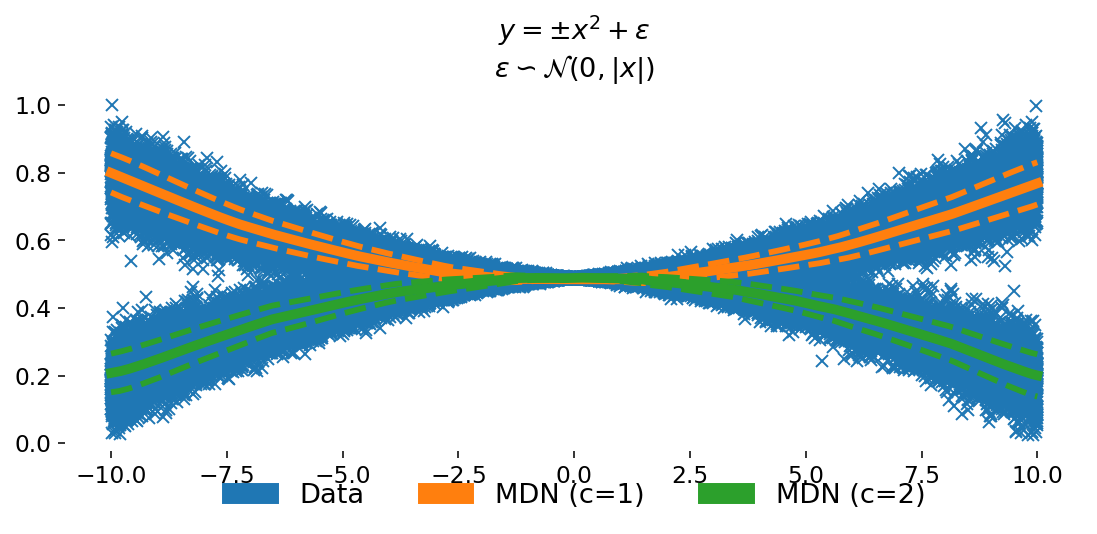

CPU times: user 245 ms, sys: 4.51 ms, total: 250 ms
Wall time: 88.5 ms


In [21]:
%%time
# Plot our results for this example

fig = plt.figure(figsize=(x_size,y_size), dpi=dpi)
ax = plt.gca()

ax.set_title(r"$y = \pm x^2 + \epsilon$"+"\n"+r"$\epsilon\backsim\mathcal{N}(0,|x|)$", fontsize=alt_font_size)
ax.plot(x_train,y_train, "x",alpha=1, color=sns.color_palette()[0])

for mx in range(components):
    plt.plot(s,mu_pred[:,mx], color=sns.color_palette()[1+mx], linewidth=5, linestyle='-', markersize=3)
    plt.plot(s,mu_pred[:,mx]-sigma_pred[:,mx], color=sns.color_palette()[1+mx],linewidth=3, linestyle='--', markersize=3)
    plt.plot(s,mu_pred[:,mx]+sigma_pred[:,mx], color=sns.color_palette()[1+mx],linewidth=3, linestyle='--', markersize=3)

remove_ax_window(ax)

data_leg = mpatches.Patch(color=sns.color_palette()[0])
data_mdn1 = mpatches.Patch(color=sns.color_palette()[1])
data_mdn2 = mpatches.Patch(color=sns.color_palette()[2])

ax.legend(handles = [data_leg, data_mdn1, data_mdn2],
          labels = ["Data", "MDN (c=1)", "MDN (c=2)"],
          loc=9, borderaxespad=0.1, framealpha=1.0, fancybox=True,
          bbox_to_anchor=(0.5, -0.05), ncol=6, shadow=True, frameon=False,
          fontsize=alt_font_size)

plt.tight_layout()

if save_figure:
    plt.savefig("graphics/mdn_nonlinear_prediction.png", format='png',dpi=dpi, bbox_inches='tight')

plt.show()

We can see that the MDN is very well able to capture the distribution using the 2 seperate components, each time we have a 50 percent of picking the upper branch and 50% the lower, this allows to capture the bimodal nature.

We can see below the mixture distribution with 2 peaks at x = 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


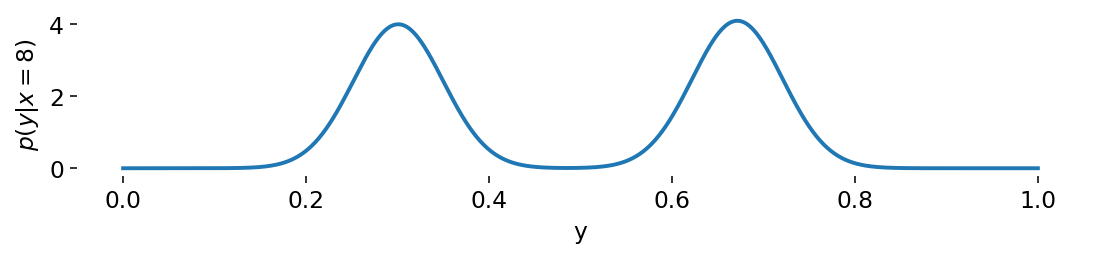

In [22]:
alpha, mu, sigma = slice_parameter_vectors(mdn_2.predict(np.array([[8.]], dtype=np.float32)))

gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,
            scale=sigma))

x = np.linspace(0,1,int(1e3))
pyx = gm.prob(x)

fig = plt.figure(figsize=(x_size,int(y_size/2)), dpi=dpi)
ax = plt.gca()

ax.plot(x,pyx,alpha=1, color=sns.color_palette()[0], linewidth=2)

ax.set_xlabel(r"y")
ax.set_ylabel(r"$p(y|x=8)$")

remove_ax_window(ax)

plt.tight_layout()

if save_figure:
    plt.savefig("graphics/mdn_x8_density.png", format='png',dpi=dpi, bbox_inches='tight')

plt.show()

Now we train DNN

In [23]:
%%time
dnn_2.fit(x=x_train, y=y_train,epochs=200, validation_data=(x_test, y_test), callbacks=[mon], batch_size=128, verbose=0)
lr_2 = LinearRegression()
lr_2.fit(x_train, y_train)

CPU times: user 20.8 s, sys: 4.74 s, total: 25.6 s
Wall time: 12.9 s


LinearRegression()

And finally we evaluate the losses for each of the models

In [24]:
eval_null_model(y_test)
eval_linear_model(x_test, y_test, lr_2)
eval_dnn_model(x_test, y_test, dnn_2)
eval_mdn_model(x_test, y_test, mdn_2)

NULL-MSE: 0.020
NULL-NLL: -0.547

LIN-MSE: 0.020
LIN-NLL: -0.547

DNN-MSE: 0.020
DNN-NLL: -0.547

MDN-MSE: 0.020
MDN-NLL: -1.754



Can see that MSE fails as a metric it is unable to tell the methods apart. The MDN very much outperforms the other 3 in NLL as it is able to capture the bimodal nature